In [1]:
import torch
import random
import pickle
import time
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sidemethods import load_richardson_data, convert_to_float
from PIL import Image
from scipy.stats import spearmanr
from transformers import AutoProcessor, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# local path to model repository on our servers
server_model_path = "/mounts/data/corp/huggingface/"
# loading the original human data as vectors for each action word
_, richardson_data, richardson_normed = load_richardson_data()
action_words = richardson_normed.keys()

# OpenAI GPT Experiments

In [2]:
import openai

RATE_LIMIT = 0.5 # seconds after every OpenAI API call
#with open("../../hf.key", "r") as f_in:
#    hf_key = f_in.readline().strip()

api_key = open('../../openai.key', 'r').read()
openai.api_key = api_key

In [12]:
#model_name = "text-davinci-003" # instr
#model_name = "text-davinci-002" # base  - THIS WAS NOT THE BASE!
#model_name = "gpt-3.5-turbo-0613"
#model_name = "gpt-3.5-turbo"
#model_name = "gpt-3.5-turbo-instruct"
model_name = "gpt-4"

#model_name = "davinci-002"

In [15]:
gpt_choices = dict()
arrows = ['↑', '↓', '←', '→']

def find_earliest_string(strings, target_string):
    found_strings = [s for s in strings if s in target_string]
    return min(found_strings, key=target_string.find, default=None)

with open("results/UNICODE_"+model_name+"_responses.txt", "w") as f_out:
    for action_word in tqdm(action_words): 

        if action_word == 0:
            continue

        ### PROMPT DEFINED HERE
        for arrow_list in list(itertools.permutations(arrows)):
            
            prompt = "Given the concepts: "+", ".join(arrow_list)+". For the CONCEPT that best represent the event '"+action_word+"', what would you choose?" # I would choose (for chat model)
            analogy_addition = " Explain the analogy (ANALOGY:), then provide one concept ("+", ".join(arrow_list)+") (CONCEPT:).\nANALOGY: "
            # provide one of the four concepts ("+", ".join(arrow_list)+") that best represent the event based on the analogy

            if "gpt-4" in model_name:
                system_message="You are a participant in a research experiment. Even if the answer is subjective, provide it. Do not say it is subjective."
                
                result = openai.chat.completions.create(                                        
                    model=model_name,
                    messages=[ {"role": "system", "content": system_message},
                        {"role": "user", "content": prompt+analogy_addition} ],
                    temperature=0,
                    max_tokens=80,
                )

                generated_answer = result.choices[0].message.content
                if "subjective" in generated_answer:
                    print("Subjective problem generated.")
            else:
                gpt_response = openai.completions.create(
                                                model=model_name,
                                                prompt=prompt+analogy_addition,
                                                temperature=0,
                                                max_tokens=80
                                                )  
                generated_answer = gpt_response.choices[0].text
            time.sleep(RATE_LIMIT)
            counted = False

            if action_word not in gpt_choices.keys():
                gpt_choices[action_word] = [0,0,0,0]
            

            
            choice = None
            if "CONCEPT: " in generated_answer:
                choice = generated_answer.split("CONCEPT: ")[1].split("\n")[0].lower()
            else:
                choice = find_earliest_string(arrows, generated_answer)

            if choice in arrows:
                gpt_choices[action_word][arrows.index(choice)]+=1
                counted = True

            if sum(gpt_choices[action_word]) > 24:
                print("Too many arrows in response.")

            f_out.write(action_word+"\t"+", ".join(arrow_list)+"\t"+generated_answer+"\n")

print(gpt_choices)

# 10m GPT-3
# 15min GPT-4

100%|██████████| 30/30 [47:01<00:00, 94.04s/it] 

{'fled': [0, 1, 23, 0], 'pointed at': [0, 0, 0, 23], 'pulled': [0, 2, 22, 0], 'pushed': [0, 0, 2, 22], 'walked': [0, 0, 0, 24], 'hunted': [0, 6, 10, 8], 'impacted': [0, 12, 3, 8], 'perched': [16, 8, 0, 0], 'showed': [0, 0, 0, 24], 'smashed': [0, 22, 0, 2], 'bombed': [0, 24, 0, 0], 'flew': [23, 0, 0, 0], 'floated': [24, 0, 0, 0], 'lifted': [24, 0, 0, 0], 'sank': [0, 24, 0, 0], 'argued with': [0, 1, 16, 2], 'gave to': [0, 0, 0, 23], 'offended': [0, 13, 11, 0], 'rushed': [0, 0, 0, 24], 'warned': [2, 0, 16, 0], 'owned': [3, 9, 2, 10], 'regretted': [0, 0, 24, 0], 'rested': [0, 15, 3, 3], 'tempted': [0, 1, 10, 13], 'wanted': [3, 0, 0, 21], 'hoped': [9, 0, 0, 15], 'increased': [24, 0, 0, 0], 'obeyed': [0, 0, 0, 24], 'respected': [24, 0, 0, 0], 'succeeded': [9, 0, 0, 15]}


In [16]:
print(gpt_choices)

{'fled': [0, 1, 23, 0], 'pointed at': [0, 0, 0, 23], 'pulled': [0, 2, 22, 0], 'pushed': [0, 0, 2, 22], 'walked': [0, 0, 0, 24], 'hunted': [0, 6, 10, 8], 'impacted': [0, 12, 3, 8], 'perched': [16, 8, 0, 0], 'showed': [0, 0, 0, 24], 'smashed': [0, 22, 0, 2], 'bombed': [0, 24, 0, 0], 'flew': [23, 0, 0, 0], 'floated': [24, 0, 0, 0], 'lifted': [24, 0, 0, 0], 'sank': [0, 24, 0, 0], 'argued with': [0, 1, 16, 2], 'gave to': [0, 0, 0, 23], 'offended': [0, 13, 11, 0], 'rushed': [0, 0, 0, 24], 'warned': [2, 0, 16, 0], 'owned': [3, 9, 2, 10], 'regretted': [0, 0, 24, 0], 'rested': [0, 15, 3, 3], 'tempted': [0, 1, 10, 13], 'wanted': [3, 0, 0, 21], 'hoped': [9, 0, 0, 15], 'increased': [24, 0, 0, 0], 'obeyed': [0, 0, 0, 24], 'respected': [24, 0, 0, 0], 'succeeded': [9, 0, 0, 15]}


### Storing experimental results

In [17]:
to_store = input("Should the result for "+model_name+" be stored? (y/n):")

if to_store == "y":

    with open("results/UNICODE_"+model_name+"_selections.txt", "w") as f_out:
        f_out.write("Action\tUP\tDOWN\tLEFT\tRIGHT\n")
        for k,v in gpt_choices.items():
            f_out.write(k+"\t"+"\t".join([str(x) for x in v])+"\n")
    

### Loading results

In [13]:
model_choices = dict()
with open("results/UNICODE_"+model_name+"_selections.txt", "r") as f_in:
    lines = f_in.readlines()

for idx,line in enumerate(lines):
    if idx == 0:
        continue
    parts = line.split("\t")
    parts[-1].replace("\n","")
    model_choices[parts[0]] = [int(x) for x in parts[1:]]

### Cosine similarity

In [14]:
similarity_scores_items = {}
similarity_scores_constructs = {'Horizontal':0, 'Neutral':0, 'Vertical':0, 'Horizon.':0, 'Neutr.':0, 'Vertic.':0}

for idx, key in enumerate(richardson_data):

    # for each item
    vec1 = np.array(richardson_data[key])
    vec2 = np.array(model_choices[key])
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    similarity_scores_items[key] = similarity

print(similarity_scores_items)

count = 0
for i in range(0,len(similarity_scores_items),5): # every 5th item is a different construct 
    current_constr = list(similarity_scores_constructs.keys())[count]
    constr_sum = round((sum(list(similarity_scores_items.values())[i:i+4])/5),4)
    similarity_scores_constructs[current_constr] = constr_sum
    count+=1

print(similarity_scores_constructs)

{'fled': 0.9914674498316741, 'pointed at': 0.9959526344048991, 'pulled': 0.9819163103016799, 'pushed': 0.9928903742989388, 'walked': 0.924763039831037, 'hunted': 0.6749930122992548, 'impacted': 0.9044632993112556, 'perched': 0.5777008474113926, 'showed': 0.955890973355183, 'smashed': 0.9489450007307834, 'bombed': 0.9953971353008849, 'flew': 0.6267874230324818, 'floated': 0.5004452036271663, 'lifted': 0.9936284354654159, 'sank': 0.953734413319121, 'argued with': 0.20275435561101052, 'gave to': 0.9876599359978278, 'offended': 0.7450683565115055, 'rushed': 0.8933406045639222, 'warned': 0.10507737261391767, 'owned': 0.7747050324069915, 'regretted': 0.7670897312644317, 'rested': 0.7775204592811594, 'tempted': 0.8867693458631611, 'wanted': 0.9581903261591026, 'hoped': 0.8714564729922556, 'increased': 0.9799102451987528, 'obeyed': 0.12131775997823994, 'respected': 0.8581257823662447, 'succeeded': 0.5658934604039882}
{'Horizontal': 0.7924, 'Neutral': 0.6226, 'Vertical': 0.6233, 'Horizon.': 0.5

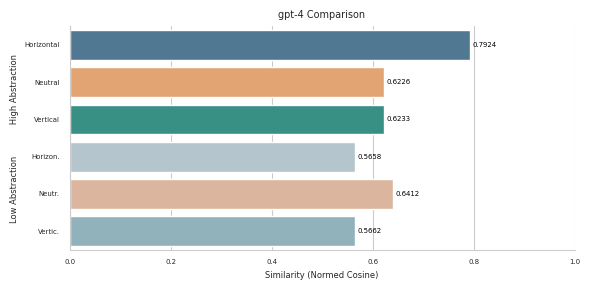

In [15]:
data = similarity_scores_constructs
custom_palette = ['#457b9d', '#f4a261', '#2a9d8f', '#b0c6d1', '#e5b293', '#8ab6c1']

plt.figure(figsize=(6, 3))
sns.set_style("whitegrid")
sns.barplot(x=list(data.values()), y=list(data.keys()), palette=custom_palette)

plt.xlabel('Similarity (Normed Cosine)', fontsize=6)
plt.ylabel('Low Abstraction            High Abstraction', fontsize=6)
plt.title(model_name+' Comparison', fontsize=7)

for i, value in enumerate(data.values()):
    plt.text(value + 0.005, i, f'{value:.4f}', va='center', fontsize=5, color='black')

plt.xlim(0, 1)
sns.despine()
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.tight_layout()
plt.savefig("results/UNICODE_"+model_name+"_CosSim.png")
plt.show()


In [16]:
# Check if file TEXT_average_similarities.txt exists, else create it
try:
    with open("results/UNICODE_average_similarities.txt", "r") as f_in:
        lines = f_in.readlines()
except FileNotFoundError:
    with open("results/UNICODE_average_similarities.txt", "w") as f_out:
        f_out.write("Model\tAverage Similarity\n")
        f_out.close()


average_sim = sum(similarity_scores_constructs.values())/len(similarity_scores_constructs.values())
print("Average similarity between human choice and model choices is: ", round(average_sim,5))

# Write the average similarity to a text file with the name of the model
# Model name is the first part of the line in the file
# Check if entry for current model already exists, else append

with open("results/UNICODE_average_similarities.txt", "r") as f_in:
    lines = f_in.readlines()

with open("results/UNICODE_average_similarities.txt", "w") as f_out:
    for line in lines:
        if line.startswith(model_name):
            line = model_name+"\t"+str(average_sim)+"\n"
        f_out.write(line)
        # append average similarity if model not yet in file
    if not any(model_name in line for line in lines):
        f_out.write(model_name+"\t"+str(average_sim)+"\n")



Average similarity between human choice and model choices is:  0.63525


In [17]:
print("Human % distrib.:", richardson_data)
print("Model distrib.:", model_choices)
model_percentages = {k:[round(100*(x/24),5) for x in entries] for k, entries in model_choices.items()}
print("Model % distrib.:", model_percentages)

Human % distrib.: {'fled': [7.2, 4.2, 80.8, 7.8], 'pointed at': [7.2, 3.6, 0.0, 89.2], 'pulled': [6.0, 5.4, 75.4, 13.2], 'pushed': [7.2, 3.6, 1.2, 88.0], 'walked': [9.0, 3.6, 24.0, 62.9], 'hunted': [9.6, 20.4, 1.8, 68.3], 'impacted': [7.2, 37.1, 3.0, 52.7], 'perched': [12.0, 76.0, 6.6, 5.4], 'showed': [15.0, 9.0, 10.2, 65.9], 'smashed': [3.6, 66.5, 1.2, 28.7], 'bombed': [4.8, 86.8, 1.8, 6.6], 'flew': [37.7, 44.3, 15.0, 3.0], 'floated': [32.9, 56.3, 7.8, 3.0], 'lifted': [87.4, 9.6, 2.4, 0.6], 'sank': [22.2, 71.9, 4.2, 1.8], 'argued with': [11.4, 13.8, 12.6, 62.3], 'gave to': [8.4, 9.6, 1.2, 80.8], 'offended': [9.0, 31.7, 24.6, 34.7], 'rushed': [10.2, 10.8, 23.4, 55.1], 'warned': [10.8, 22.2, 6.0, 61.1], 'owned': [5.4, 55.7, 18.6, 20.4], 'regretted': [19.8, 24.0, 41.3, 15.0], 'rested': [14.4, 36.5, 40.1, 9.0], 'tempted': [16.8, 11.4, 45.5, 26.3], 'wanted': [15.6, 7.8, 15.6, 61.1], 'hoped': [45.5, 15.6, 7.2, 31.7], 'increased': [73.7, 7.2, 9.6, 9.0], 'obeyed': [22.8, 4.2, 64.7, 8.4], 'res

In [18]:
# Assuming you have two dictionaries: model_percentages and richardson_data
concepts = ["C:◯↑▢", 'D:◯↓▢', 'B:◯←▢ ', 'A:◯→▢']
spearmanr_values = {}

for concept in concepts:
    model_values = [model_percentages[key][concepts.index(concept)] for key in model_percentages]
    richardson_values = [richardson_data[key][concepts.index(concept)] for key in richardson_data]

    spearmanr_result = spearmanr(model_values, richardson_values)
    spearmanr_values[concept] = spearmanr_result.correlation, spearmanr_result.pvalue

In [19]:
# Check if file TEXT_spearmanr.txt exists, else create it

try:
    with open("results/UNICODE_spearmanr.txt", "r") as f_in:
        lines = f_in.readlines()
except FileNotFoundError:
    with open("results/UNICODE_spearmanr.txt", "w") as f_out:
        f_out.write("Model\tC\tD\tB\tA\n")
        f_out.close()

with open("results/UNICODE_spearmanr.txt", "r") as f_in:
    lines = f_in.readlines()

with open("results/UNICODE_spearmanr.txt", "w") as f_out:
    for line in lines:
        if line.startswith(model_name):
            line = model_name+"\t"+'\t'.join([','.join(map(str, tup)) for tup in spearmanr_values.values()])+"\n"
        f_out.write(line)
        # append average similarity if model not yet in file
    if not any(model_name in line for line in lines):
        f_out.write(model_name+"\t"+'\t'.join([','.join(map(str, tup)) for tup in spearmanr_values.values()])+"\n")

spearmanr_values


{'C:◯↑▢': (0.6386430348038552, 0.00014590423589997043),
 'D:◯↓▢': (0.6000827607748805, 0.0004560096324532467),
 'B:◯←▢ ': (0.38011120392819103, 0.03826671093394942),
 'A:◯→▢': (0.603774221601017, 0.0004114622250953462)}

# Visualisation of Choice Distributions

/tmp/ipykernel_3317042/833082518.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


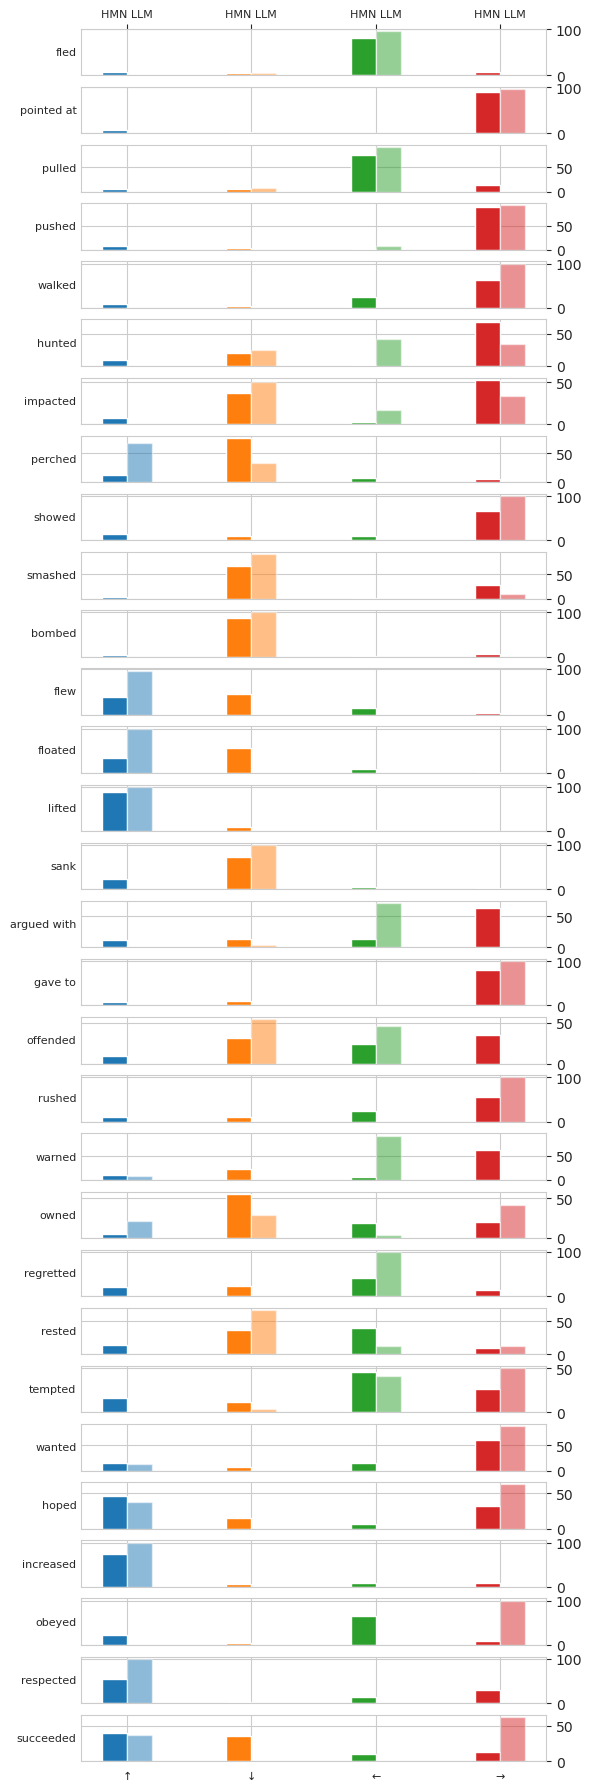

In [20]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data_old = richardson_data
data_new = model_percentages

action_names = list(data_old.keys())
num_actions = len(action_names)
num_subplots = len(data_old[action_names[0]])

fig_width = 6
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create a GridSpec layout
fig = plt.figure(figsize=(fig_width, .75*num_actions))  # Adjust the height factor as needed
gs = gridspec.GridSpec(num_actions, 1, figure=fig, hspace=0.25)  # You can adjust hspace as needed

bar_width_old = 0.2  # Width of the old bars
bar_width_new = bar_width_old /2  # Width of the new bars

for i, action in enumerate(action_names):

    values_old = data_old[action]
    values_new = data_new[action]
    
    positions_old = np.arange(num_subplots) 
    positions_new = positions_old + bar_width_old  # Shift the new bars to the right
    
    bottom_old = np.zeros(num_subplots)
    bottom_new = np.zeros(num_subplots)
    
    ax = fig.add_subplot(gs[i, 0])
    
    for j, (value_old, value_new) in enumerate(zip(values_old, values_new)):
        color_A = colors[j]

        ax.bar(positions_old[j]-.1, value_old, bottom=bottom_old[j], width=bar_width_old, color=color_A)
        new_bar_x = positions_new[j] #+ bar_width_new / 2  # Middle of the new bar
        ax.bar(positions_new[j]-.1, value_new, bottom=bottom_new[j], width=bar_width_new*2, color=color_A, alpha=0.5)
        
        bottom_old[j] += value_old
        bottom_new[j] += value_new
        

    ax.set_xticks(positions_old)
    ax.set_xticklabels([])
    
    if i == num_actions - 1:
        ax.set_xticklabels(['↑', '↓', '←', '→'], fontsize=8)  # Adjust fontsize as needed
    if i == 0 :
        ax.set_xticklabels(["HMN LLM", 'HMN LLM', 'HMN LLM', 'HMN LLM'], fontsize=8)  # Adjust fontsize as needed
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')
        
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
    ax.text(-.01, 0.5, action, transform=ax.transAxes, rotation=0, va='center', ha='right', fontsize=8)

plt.tight_layout()
plt.savefig("results/UNICODE_"+model_name+"_Choices.png")
plt.show()
